# Random incidence

In [1]:
from inputresolver import resolve, invert_edges, flatten_order, reassigneq, direct_eqs, flatten_and_transform_condensation, default_in_raw, eqvars, reassign, default_in, getallvars
from representations import digraph_repr, draw_dsm, drawbipartite, draw, bipartite_repr, tree_incidence, render_tree
from datastructures import notation_from_tree
from compute import Var, adda, addf, Model, RefNode, Function, END, INTER, Evaluable, addsolver,OPT
from compute import buildidpvars
from notation import generate_execution, mapping, default_sequence, make_acyclic, graphs_from_incidence, all_residuals, duplicate_nodes
from notationcompute import explicit, solver, optsolver
from testproblems import generate_random_prob
from random import Random, sample, randint
from anytree import PreOrderIter
import random
import copy
import sympy as sp
import numpy as np
from functools import reduce
import networkx as nx
import operator
from utils import normalize_name
import matplotlib.pyplot as plt
import openmdao.api as om
import pandas as pd

In [2]:
n_eqs = 10
n_vars = 13
seed = 42#8 is triang#seed 10 is nice
sparsity = 1.3 #1.7
eqv, varinc, dout = generate_random_prob(n_eqs, n_vars, seed, sparsity)

In [3]:
eqs=direct_eqs(eqv, dout)

In [4]:
eqs

{0: (19, (13, 14, 16, 17)),
 1: (11, (10, 15)),
 2: (14, (11, 12, 15, 16, 17, 20, 21, 22)),
 3: (10, (14, 18, 19)),
 4: (12, (10, 17, 18)),
 5: (13, (12, 17, 19, 20)),
 6: (17, (20, 22)),
 7: (15, (10, 11, 19)),
 8: (18, (10, 17)),
 9: (20, (10, 13))}

In [4]:
# A = np.zeros((n_eqs, n_vars)).astype(int)
# permutation = range(n_eqs, n_vars+n_eqs)
# for idx, (out,varsineq) in eqs.items():
#     for var in varsineq+(out,):
#         col = permutation.index(var)
#         A[idx,col] = 1
# print('A=[{}]'.format(';\n '.join([' '.join([str(elt) for elt in row]) for row in A])))

# Generate test problem equations

In [44]:
rng = np.random.default_rng(12345)
def smallrand(rng, n=1):
    newn = np.round(rng.uniform(low=-1, high=1),n)
    if newn == 0.:
        return smallrand()
    return newn

In [47]:
def generate_partitions(rng, vrs):
    rvrs = copy.copy(list(vrs))
    rng.shuffle(rvrs)
    p = []
    while len(rvrs) >= 3:
        ri = rng.integers(2,4)
        p.append((smallrand(rng), rvrs[:ri]))
        rvrs = rvrs[ri:]
    if rvrs:
        p.append((smallrand(rng), rvrs))
    return p

In [48]:
generate_partitions(rng, [1,2,3,4,5,6,7,8,9,10])

[(0.8, [1, 10]), (-0.3, [4, 6]), (0.5, [3, 7, 2]), (-0.8, [9, 8, 5])]

In [7]:
def random_function(rng, vrs, partition):
    return sum([key*reduce(operator.mul, (vrs[var] for var in val)) for key, val in partition])+smallrand(rng)

In [8]:
partitions = {idx:generate_partitions(eqvars) for idx,eqvars in eqv.items()}

In [9]:
vrs = {n_eqs+idx: Var('x_{{{}}}'.format(idx)) for idx in range(n_vars)}
vrsn = {normalize_name(var.name):var for var in vrs.values()}
fxeqs = dict()
fxeqs_opt = dict()
fxdir = dict()

In [10]:
reseqs = {idx: random_function(vrs, partitions[idx])+smallrand() for idx,eqvars in eqv.items()}

In [11]:
reseqs

{0: -0.3*x_{3}*x_{7}*x_{9} + 0.2*x_{4}*x_{6} - 0.7,
 1: 0.9*x_{0} + 0.3*x_{1}*x_{5} - 1.0,
 2: -0.7*x_{10} - 0.3*x_{11}*x_{1}*x_{4} - 0.8*x_{12}*x_{2}*x_{6} - 0.6*x_{5}*x_{7} - 0.8,
 3: 0.6*x_{0}*x_{4} - 0.6*x_{8}*x_{9} - 0.7,
 4: 0.7*x_{0}*x_{2} + 0.2*x_{7}*x_{8} - 0.9,
 5: 0.1*x_{10}*x_{2} + 0.9*x_{3}*x_{7}*x_{9} - 0.9,
 6: -0.5*x_{10}*x_{12}*x_{7} - 1.1,
 7: -0.3*x_{0}*x_{5}*x_{9} + 0.8*x_{1} + 0.1,
 8: -0.5*x_{0}*x_{7} - 0.3*x_{8} + 0.1,
 9: -0.4*x_{0} + 0.3*x_{10}*x_{3} + 0.7}

# Default inputs architectures

In [12]:
model = Model()
m = RefNode(name='/', ref=model)

In [13]:
for idx, (left,_) in sorted(eqs.items()):
    leftvar = vrs[left]
    fxeq = sp.simplify(reassigneq(None, reseqs[idx], leftvar))
    _, fx, node = adda(m, leftvar, fxeq, returnfx=True, returnnode=True)
    fxdir[idx] = node
    fxeqs[fx] = reseqs[idx]

In [14]:
objective_fx = sum([(vrsn[vr]-1)**2 for vr in random.sample(['x{}'.format(elt-n_eqs) for elt in dout.values()],3)])

In [15]:
#addf(m, objective_fx, name='f');

In [16]:
# fxdir[3].node_type=END
# fxdir[9].node_type=END

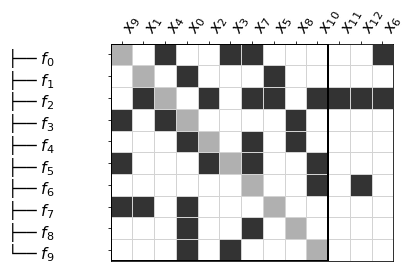

In [18]:
seq1 = default_sequence(m)
fig, ax = tree_incidence(m, eqvars(model.eqs), model.outset, seq1, figsize=(6,6));
plt.sca(ax)
#plt.savefig('figures/polynomial_orig_2coupled.png', dpi=600, bbox_inches='tight')

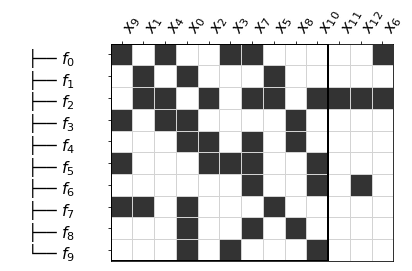

In [19]:
arch2 = all_residuals(m)
seq2 = default_sequence(arch2)
fig, ax = tree_incidence(arch2, eqvars(model.eqs), model.outset, seq2, figsize=(6,6));

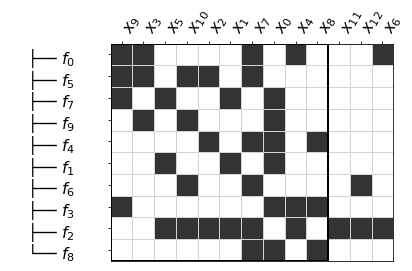

In [20]:
G, graphs = graphs_from_incidence(m, from_root=True)
arch3 = make_acyclic(m, graphs, mdf=True)
seq3 = default_sequence(arch3)
fig, ax = tree_incidence(arch3, eqvars(model.eqs), model.outset, seq3, figsize=(6,6));

# Structurally optimized inputs

In [21]:
_, edges_original = bipartite_repr(eqv)
avrs = getallvars(eqs, sympy=False)
eqns = eqs.keys()
edges = invert_edges(edges_original)

In [22]:
output = resolve(eqns, avrs, edges, 50)

Using license file C:\Users\johan\gurobi.lic
Academic license - for non-commercial use only - expires 2022-09-25


In [23]:
soutput = sorted(output, key=lambda x: x['CLEN'])

In [24]:
out_opt = dict(soutput[0]['SOL'])

In [25]:
out_opt

{0: 16, 1: 15, 2: 21, 3: 14, 4: 12, 5: 19, 6: 22, 7: 11, 8: 17, 9: 10}

In [26]:
nrev_lookup = {var:key for key,var in out_opt.items()}

In [27]:
model_optinp = Model()
m2 = RefNode(name='/', ref=model_optinp)

In [28]:
for idx, eq in sorted(reseqs.items()):
    left = out_opt[idx]
    leftvar = vrs[left]
    fxeq = sp.simplify(reassigneq(None, eq, leftvar))
    _, fx = adda(m2, leftvar, fxeq, returnfx=True)
    fxeqs_opt[fx] = reseqs[idx]

In [29]:
eqs_optinp, eqv_optinp, dout_optinp, dins_optinp = model_optinp.data_structures()

In [30]:
G, graphs = graphs_from_incidence(m2, from_root=True)
arch4 = make_acyclic(m2, graphs)
arch5 = make_acyclic(m2, graphs)

In [31]:
fobj = addf(arch5, objective_fx, name='f')
addsolver(arch5, arch5.children,[(fobj,dins_optinp)]);

In [32]:
render_tree(arch4, display_type=True)

/               
├── f_{9}, INTER
├── f_{8}, INTER
├── f_{4}, INTER
├── f_{6}, INTER
├── f_{5}, INTER
├── f_{3}, INTER
├── ., SOLVER   
│   ├── f_{7}, END
│   └── f_{1}, END
├── f_{0}, INTER
└── f_{2}, INTER


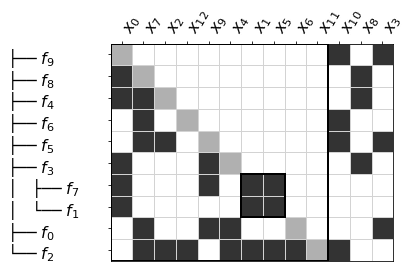

In [34]:
seq4 = default_sequence(arch4)
fig, ax = tree_incidence(arch4, eqvars(model_optinp.eqs), model_optinp.outset, seq4, figsize=(10,10));
plt.sca(ax)
#plt.savefig('figures/polynomial_triang_2coupled.png', dpi=600, bbox_inches='tight')

# For polynomial testing eqs

In [35]:
print('@var {}'.format(", ".join([normalize_name(vr.name,keep_underscore=True) for vr in vrs.values()])))
print('@var λ[1:{}];'.format(n_eqs))
for key, var in reseqs.items():
    print('h{}={};'.format(key, normalize_name(str(var), keep_underscore=True)))
print('vars=[{}]'.format(", ".join([normalize_name(vr.name,keep_underscore=True) for vr in vrs.values()])))
#print('dfdx=[{}]'.format(", ".join([str(0) if vr not in [16, 22, 21] else 'x_{}'.format(vr) for vr in vrs])))
print('h=[{}];'.format(", ".join(['h{}'.format(eq) for eq in reseqs.keys()])))

@var x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10, x_11, x_12
@var λ[1:10];
h0=-0.3*x_3*x_7*x_9 + 0.2*x_4*x_6 - 0.7;
h1=0.9*x_0 + 0.3*x_1*x_5 - 1.0;
h2=-0.7*x_10 - 0.3*x_11*x_1*x_4 - 0.8*x_12*x_2*x_6 - 0.6*x_5*x_7 - 0.8;
h3=0.6*x_0*x_4 - 0.6*x_8*x_9 - 0.7;
h4=0.7*x_0*x_2 + 0.2*x_7*x_8 - 0.9;
h5=0.1*x_10*x_2 + 0.9*x_3*x_7*x_9 - 0.9;
h6=-0.5*x_10*x_12*x_7 - 1.1;
h7=-0.3*x_0*x_5*x_9 + 0.8*x_1 + 0.1;
h8=-0.5*x_0*x_7 - 0.3*x_8 + 0.1;
h9=-0.4*x_0 + 0.3*x_10*x_3 + 0.7;
vars=[x_0, x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10, x_11, x_12]
h=[h0, h1, h2, h3, h4, h5, h6, h7, h8, h9];


# Execution order

In [37]:
exec_instructions = {
    'arch2': generate_execution(notation_from_tree(arch2, model.outset)),
    'arch3': generate_execution(notation_from_tree(arch3, model.outset)),
    'arch4': generate_execution(notation_from_tree(arch4, model_optinp.outset))
}

# Build openMDAO problem

In [38]:
#objective = Function('f', END)
#optin[objective] = (None,objective_fx)

In [54]:
eqsd, _,_,_ = model.data_structures()

In [55]:
eqsd

{f0: (x_9, (0.666666666666667*x_4*x_6 - 2.33333333333333)/(x_3*x_7)),
 f1: (x_1, (3.33333333333333 - 3.0*x_0)/x_5),
 f2: (x_4,
  -(2.33333333333333*x_10 + 2.66666666666667*x_12*x_2*x_6 + 2.0*x_5*x_7 + 2.66666666666667)/(x_11*x_1)),
 f3: (x_0, (x_8*x_9 + 1.16666666666667)/x_4),
 f4: (x_2, (-0.285714285714286*x_7*x_8 + 1.28571428571429)/x_0),
 f5: (x_3, (-0.111111111111111*x_10*x_2 + 1.0)/(x_7*x_9)),
 f6: (x_7, -2.2/(x_10*x_12)),
 f7: (x_5, (2.66666666666667*x_1 + 0.333333333333333)/(x_0*x_9)),
 f8: (x_8, -1.66666666666667*x_0*x_7 + 0.333333333333333),
 f9: (x_10, (1.33333333333333*x_0 - 2.33333333333333)/x_3)}

In [39]:
for vr in vrs.values():
    vr.name = normalize_name(vr.name, keep_underscore=True)
for fx in fxeqs.keys():
    fx.name = normalize_name(fx.name, keep_underscore=False)
for fx in fxeqs_opt.keys():
    fx.name = normalize_name(fx.name, keep_underscore=False)

In [40]:
inst_mapping = {
    'exp': lambda *args: explicit(groups, eqs, *args),
    'solver': lambda *args: solver(groups, optin, *args, maxiter=200)
}

In [147]:
mdl = model#model_optinp
fxeq = fxeqs#fxeqs_opt
arch = 'arch2'

In [ ]:
def build_archi(model, fxeqs, exec_instructions_pick):
    eqs, eqv, dout, dins = mdl.data_structures()
    optin = {key:(None, val) for key,val in fxeq.items()}
    mdao_in = [str(elt) for elt in dins]
    
    # Build MDO model
    prob = om.Problem()
    mdo_model = prob.model
    groups = {0:mdo_model}
    
    buildidpvars(mdao_in, mdo_model)
    
    for comp_type, *comp_args in exec_instructions_pick:
        inst_mapping[comp_type](*comp_args)
    
    prob.setup();
    return prob

In [43]:
def generate_x0(varnames=None, optres=None):
    varnames = optres.values() if optres else varnames
    x0 = {name:(optres.get(name, None) if optres else 0.1)+np.random.uniform(10,20)*np.random.randint(-1,1) for name in varnames}
    return x0

In [ ]:
def run_and_save_archi(x0, vrs, optres_all):
    for key,val in x0.items():
        prob.set_val(key,val)
    prob.run_model()
    optres = extractvals(prob, vrs)
    optres_all.append(extractvals(prob, vrs))
    return optres

In [148]:
eqs, eqv, dout, dins = mdl.data_structures()

In [149]:
#equality constraints
optin = {key:(None, val) for key,val in fxeq.items()}

In [150]:
mdao_in = [str(elt) for elt in dins]

In [151]:
prob = om.Problem()
mdo_model = prob.model
groups = {0:mdo_model}

In [152]:
buildidpvars(mdao_in, mdo_model)

In [153]:
exec_instructions_pick = exec_instructions[arch]

In [154]:
for comp_type, *comp_args in exec_instructions_pick:
    inst_mapping[comp_type](*comp_args)

In [155]:
prob.setup();

In [213]:
zero_instead_of_val = True
x0 = {name:(0.1 if zero_instead_of_val else val)+np.random.uniform(10,20)*np.random.randint(-1,1) for name, val in optres.items()}
for key,val in x0.items():
    prob.set_val(key,val)

In [214]:
#for elt in mdao_in:
#    prob.set_val(elt, 1.0)

In [215]:
for elt in mdao_in:
    prob.set_val(elt, optres[elt])

In [216]:
# for elt in vrs.values():
#     prob.set_val(elt.name,np.random.randint(-10,10))

In [217]:
prob.run_model()


group1
NL: NewtonSolver 'NL: Newton' on system 'group1' failed to converge in 200 iterations.


In [201]:
optres_all.append(extractvals(prob, vrs))

In [202]:
pd.DataFrame.from_dict(optres_all)

,x_0,x_1,x_2,x_3,x_4,x_5,x_6,x_7,x_8,x_9,x_10,x_11,x_12
0,2.500000,-4.855545,0.532571,1.000000,-1.885397,0.858126,-2.604883,-0.160000,1.000000,-5.880159,1.000000,5.040266,13.75
1,1.935346,-4.329879,0.664983,0.018300,-1.344897,0.571079,-2.604883,-0.011848,0.371550,-10.145360,13.504409,5.040266,13.75
2,2.500000,-4.855545,0.532571,1.000000,-1.885397,0.858126,-2.604883,-0.160000,1.000000,-5.880159,1.000000,5.040266,13.75
3,-0.606127,-0.084239,5.312771,-80.884709,-1.906270,-61.155899,-2.604883,-4.119543,-3.828275,0.002932,0.038839,5.040266,13.75
4,-0.868336,-0.002407,-1.477456,0.573109,-1.343632,-2466.781806,-2.604883,0.026266,0.371346,0.000153,-6.091539,5.040266,13.75


In [140]:
optres = extractvals(prob, vrs)

In [143]:
optres_all = []
def extractvals(prob, vrs):
    return {key.name: prob.get_val(key.name)[0] for key in 
          vrs.values()}

In [176]:
optres2 = extractvals(prob, vrs)

In [180]:
[Evaluable.fromsympy(eq).evaldict(optres2) for eq in fxeq.values()]

[2.1094237467877974e-15,
 1.3322676295501878e-15,
 -4.0190073491430667e-14,
 1.7541523789077473e-14,
 -1.4432899320127035e-15,
 1.887379141862766e-15,
 1.6608936448392342e-13,
 -1.4155343563970746e-15,
 -2.914335439641036e-16,
 -6.306066779870889e-14]

### Tweak initial conditions

Option 1

In [38]:
for elt in vrs.values():
    prob.set_val(elt.name,np.random.randint(-10,10))

Option 2

In [118]:
for name, val in optres.items():
    prob.set_val(name,1.7*val)

### Run model

In [119]:
#prob.run_model()
#res_default = {key.name: prob.get_val(key.name)[0] for key in 
#          vrs.values()}

In [120]:
prob.set_solver_print(level=1)
prob.driver = om.ScipyOptimizeDriver()
# prob.driver.options['optimizer'] = 'differential_evolution'
prob.driver.options['maxiter'] = 300 
prob.run_driver();


group1
NL: Newton Converged in 5 iterations

group1
NL: Newton Converged in 0 iterations

group1
NL: Newton Converged in 4 iterations

group1
NL: Newton Converged in 5 iterations

group1
NL: Newton Converged in 4 iterations

group1
NL: Newton Converged in 4 iterations

group1
NL: Newton Converged in 4 iterations

group1
NL: Newton Converged in 3 iterations

group1
NL: Newton Converged in 3 iterations

group1
NL: Newton Converged in 3 iterations

group1
NL: Newton Converged in 3 iterations

group1
NL: Newton Converged in 5 iterations

group1
NL: Newton Converged in 4 iterations

group1
NL: NewtonSolver 'NL: Newton' on system 'group1' failed to converge in 20 iterations.

group1
NL: Newton Converged in 11 iterations

group1
NL: Newton Converged in 5 iterations

group1
NL: Newton Converged in 3 iterations

group1
NL: Newton Converged in 2 iterations

group1
NL: Newton Converged in 2 iterations

group1
NL: Newton Converged in 2 iterations

group1
NL: Newton Converged in 1 iterations

grou

In [121]:
mdo_model.list_outputs();

6 Explicit Output(s) in 'model'

varname  val           
-------  --------------
inp
  x_12   [-2.96767381] 
  x_6    [8.10831687]  
  x_11   [2.36962945]  
eqf3
  x_0    [-0.66666667] 
eqf9
  x_10   [0.44444444]  
eqf
  f0f    [643.91451136]


8 Implicit Output(s) in 'model'

varname                val          
---------------------  -------------
group1
  resf8f5f6f2f4f7f1f0
    x_8                [-0.65464325]
    x_3                [-0.36126889]
    x_7                [0.03287102] 
    x_4                [6.38955715] 
    x_2                [1.07494227] 
    x_5                [-3.3624134] 
    x_1                [0.10433691] 
    x_9                [26.35692325]




## Optimized inputs

In [45]:
optin_opt = {key:(None, val) for key,val in fxeqs_opt.items()}

In [46]:
objective_opt = Function('f', END)
optin_opt[objective_opt] = (None, (vrsn['x2']-1)**2+(vrsn['x7']-1)**2+(vrsn['x9']-1)**2)

In [47]:
prob_optinp = om.Problem()
mdo_model_optinp = prob_optinp.model
groups_optinp = {0:mdo_model_optinp}

In [48]:
eqs_optinp, eqv_optinp, dout_optinp, dins_optinp = model_optinp.data_structures()
mdao_in_optinp = [str(elt) for elt in dins_optinp]

In [49]:
buildidpvars(mdao_in_optinp, mdo_model_optinp)

In [50]:
inst_mapping = {
    'exp': lambda *args: explicit(groups_optinp, eqs_optinp, *args),
    'solver': lambda *args: solver(groups_optinp, optin_opt, *args)
}

In [51]:
for comp_type, *comp_args in exec_optinp:
    inst_mapping[comp_type](*comp_args)

In [52]:
optsolver(groups_optinp, optin_opt, 0, 0, mdao_in_optinp, ([],[],[objective_opt]))

In [53]:
prob_optinp.setup();

In [54]:
prob_optinp.run_model();

In [58]:
# for elt in ['x_11', 'x_12', 'x_13', 'x_14', 'x_15', 'x_17', 'x_18', 'x_19', 'x_16', 'x_21', 'x_22']:
#     prob.set_val(elt,100*optres[elt])

In [59]:
# for elt in ['x_12', 'x_17','x_19']:
#     prob.set_val(elt,np.random.randint(-500,500))

In [60]:
# for elt in ['x_21','x_16','x_22','x_11', 'x_13', 'x_14', 'x_15', 'x_18']:
#     prob.set_val(elt,np.random.randint(-100,100))

In [57]:
mdo_model_optinp.list_outputs();

14 Explicit Output(s) in 'model'

varname  val          
-------  -------------
inp
  x_7    [1.]         
  x_2    [1.]         
  x_9    [1.]         
eqf3
  x_0    [-0.66666667]
eqf9
  x_10   [0.44444444] 
eqf0
  x_1    [2.75]       
eqf7
  x_5    [-3.25]      
eqf4
  x_8    [-0.7037037] 
eqf6
  x_12   [-2.5]       
eqf2
  x_4    [0.24242424] 
eqf5
  x_3    [-0.44368471]
eqf1
  x_11   [2.30769231] 
eqf8
  x_6    [6.18777743] 
eqf
  f0f    [0.]         


0 Implicit Output(s) in 'model'




In [56]:
prob_optinp.set_solver_print(level=1)
prob_optinp.driver = om.ScipyOptimizeDriver()
prob_optinp.driver.options['maxiter'] = 300 
prob_optinp.run_driver();

Optimization terminated successfully    (Exit mode 0)
            Current function value: [0.]
            Iterations: 2
            Function evaluations: 3
            Gradient evaluations: 2
Optimization Complete
-----------------------------------


C:\Users\johan\Miniconda2\envs\mdo\lib\site-packages\autograd\tracer.py:14: UserWarning: Output seems independent of input.
  warnings.warn("Output seems independent of input.")


In [78]:
optres = {key.name: prob_optinp.get_val(key.name)[0] for key in 
          vrs.values()}

In [79]:
optres

{'x_0': -0.666666666666667,
 'x_1': 2.75,
 'x_2': 1.0,
 'x_3': -0.44368471035137425,
 'x_4': 0.24242424242424254,
 'x_5': -3.2500000000000036,
 'x_6': 6.187777426049033,
 'x_7': 1.0,
 'x_8': -0.7037037037037038,
 'x_9': 1.0,
 'x_10': 0.444444444444444,
 'x_11': 2.3076923076923097,
 'x_12': -2.5000000000000138}

## Double check

In [97]:
[Evaluable.fromsympy(eq).evaldict(optres) for eq in fxeqs.values()]

[0.0,
 0.0,
 -1.6653345369377348e-16,
 -8.326672684688674e-17,
 -2.220446049250313e-16,
 1.1102230246251565e-16,
 1.5543122344752192e-15,
 2.1094237467877974e-15,
 2.220446049250313e-16,
 -4.440892098500626e-16]